## Importing the Libraries

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from arch import arch_model
import statsmodels.api as sm
from scipy.stats import ttest_1samp
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

## Required Functions

In [2]:
def load_and_process_data(filepath: str) -> pd.DataFrame:
    """
    This function loads the dataset from a CSV file, processes the data by converting 
    specific columns to appropriate data types, sorting by date, resetting the index, and dropping 
    unnecessary columns.

    Parameters:
    filepath (str): The file path to the CSV file containing the stock data.

    Returns:
    pd.DataFrame: The processed DataFrame with cleaned and formatted data.
    """

    df = pd.read_csv(filepath, parse_dates=['Date'])
    df = convert_to_appropriate_datatypes(df)
    df.sort_values('Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    df.drop('Vol.', axis=1, inplace=True)
    return df


def convert_to_appropriate_datatypes(df: pd.DataFrame) -> pd.DataFrame:
    """
    This function converts specific columns in the input DataFrame to appropriate data types and formats.
    It handles date conversion, numeric data cleansing, percentage change processing, and the calculation 
    of volatility over a rolling window.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing stock data. It should have the following columns:
                       'Date', 'Price', 'Open', 'High', 'Low', and 'Change %'.

    Returns:
    pd.DataFrame: The modified DataFrame with updated data types, cleaned numeric columns, a renamed 'Change %' 
                  column to 'Returns', and a calculated 'Volatility' column.
    """

    df['Date'] = pd.to_datetime(df['Date'])
    numeric_columns = ['Price', 'Open', 'High', 'Low']
    for col in numeric_columns:
        if df[col].dtype == 'object':
            df[col] = df[col].str.replace(',', '').astype(float)

    if df['Change %'].dtype == 'object':
        df['Change %'] = df['Change %'].str.replace('%', '').astype(float) / 100
    df.rename(columns={'Change %': 'Returns'}, inplace=True)
    # Calculate rolling standard deviation of returns (volatility) with a 30-day window
    df['Volatility'] = df['Returns'].rolling(window=30).std()    
    return df


def compare_dates(df1: pd.DataFrame, df2: pd.DataFrame, df3: pd.DataFrame) -> bool:
    """
    This function checks whether the 'Date' columns in three provided DataFrames are identical.
    
    Parameters:
    df1 (pd.DataFrame): The first DataFrame to compare.
    df2 (pd.DataFrame): The second DataFrame to compare.
    df3 (pd.DataFrame): The third DataFrame to compare.
    
    Returns:
    bool: Returns True if the 'Date' columns in all three DataFrames are identical, False otherwise.
    """
    same_dates = df1['Date'].equals(df2['Date']) and df2['Date'].equals(df3['Date'])
    return same_dates

def plot_price_trend_with_events(df: pd.DataFrame, reg_df: pd.DataFrame, label: str, color: str):
    """
    This function plots the price trend of a given dataset along with vertical lines to highlight 
    specific regulatory event dates.

    Parameters:
    df (pd.DataFrame): The main DataFrame containing the price and date information.
    reg_df (pd.DataFrame): The DataFrame containing the regulatory event dates.
    label (str): The label to use for the plot legend (e.g., 'FTSE 350 Banks').
    color (str): The color to use for the price line.

    Returns:
    None
    """
    plt.figure(figsize=(14, 4))
    plt.plot(df['Date'], df['Price'], label=label, color=color)
    plt.title(f'Price Trend for {label}')
    plt.ylabel('Price')
    plt.xlabel('Date')
    for date in reg_df['Date']:
        plt.axvline(x=date, color='gray', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


def plot_volatility_with_events(df: pd.DataFrame, reg_df: pd.DataFrame, label: str, color: str):
    """
    This function plots the rolling volatility trend of a given dataset along with vertical lines to highlight
    specific regulatory event dates.

    Parameters:
    df (pd.DataFrame): The main DataFrame containing the volatility and date information.
    reg_df (pd.DataFrame): The DataFrame containing the regulatory event dates.
    label (str): The label to use for the plot legend (e.g., 'FTSE 350 Banks Volatility').
    color (str): The color to use for the volatility line.

    Returns:
    None
    """
    plt.figure(figsize=(14, 4))
    plt.plot(df['Date'], df['Volatility'], label=label, color=color)
    plt.title(f'Rolling Volatility for {label}')
    plt.ylabel('Volatility')
    plt.xlabel('Date')
    for date in reg_df['Date']:
        plt.axvline(x=date, color='gray', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


def get_market_reaction(full_data: pd.DataFrame, announcement_dates: pd.Series, window_size: int = 20) -> pd.DataFrame:
    """
    This function extracts market data around specific announcement dates, creating a window of data 
    before and after each announcement. The resulting data includes a window of `window_size` days before 
    and after the announcement date.

    Parameters:
    full_data (pd.DataFrame): The full dataset containing market data with a DateTime index.
    announcement_dates (pd.Series): A series of announcement dates (datetime format).
    window_size (int, optional): The number of days before and after the announcement to include in the window. 
                                 Default is 20 days.

    Returns:
    pd.DataFrame: A concatenated DataFrame containing market data for all windows around the announcement dates.
    """

    reaction_data = []

    # Loop through each announcement date
    for announcement in announcement_dates:
        # Calculate the start and end of the window around the announcement
        window_start = announcement - pd.Timedelta(days=window_size)
        window_end = announcement + pd.Timedelta(days=window_size)
        # Extract the market data within the window
        window_data = full_data.loc[window_start:window_end].copy()  # Working with a copy of the data
        # Add the announcement date for reference
        window_data.loc[:, 'Announcement_Date'] = announcement  # Use .loc to assign values to avoid warnings
        # Append the window data to the list
        reaction_data.append(window_data)
    # Concatenate all the windowed data into a single DataFrame
    return pd.concat(reaction_data)

def calculate_event_impact(df: pd.DataFrame, event_dates: pd.Series, pre_event_window: int, event_window: int, significance_level: float = 0.05) -> pd.DataFrame:
    """
    This function calculates the expected and abnormal returns around event dates. It also performs a 
    statistical test to determine the significance of the abnormal returns during the event window.

    Parameters:
    df (pd.DataFrame): The DataFrame containing stock market data, with at least 'Date' and 'Returns' columns.
    event_dates (pd.Series): A series of event dates (datetime format).
    pre_event_window (int): The number of days prior to the event date to use for calculating expected returns.
    event_window (int): The number of days after the event date to use for calculating abnormal returns.
    significance_level (float): The threshold for determining statistical significance (default is 0.05).

    Returns:
    pd.DataFrame: A DataFrame containing the event date, expected return, mean abnormal return, t-statistic, p-value, and significance.
    """
    
    # List to store the results for each event
    results = []
    
    # Loop through each event date
    for event_date in event_dates:
        # Define the pre-event window to calculate expected returns
        window_start = pd.to_datetime(event_date) - pd.Timedelta(days=pre_event_window)
        window_end = pd.to_datetime(event_date) - pd.Timedelta(days=1)
        # Define the event window to calculate abnormal returns
        event_start = pd.to_datetime(event_date)
        event_end = pd.to_datetime(event_date) + pd.Timedelta(days=event_window)
        # Calculate the mean returns in the pre-event window (expected returns)
        expected_returns = df[(df['Date'] >= window_start) & (df['Date'] <= window_end)]['Returns'].mean()
        # Calculate abnormal returns during the event window
        actual_returns = df[(df['Date'] >= event_start) & (df['Date'] <= event_end)]['Returns']
        abnormal_returns = actual_returns - expected_returns
        # Perform a t-test to check if the abnormal returns are significantly different from zero
        t_stat, p_value = ttest_1samp(abnormal_returns.dropna(), 0)
        # Store the results for this event
        results.append({
            'Event Date': event_date,
            'Expected Return': expected_returns,
            'Mean Abnormal Return': abnormal_returns.mean(),
            'T-Statistic': t_stat,
            'P-Value': p_value
        })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Filter for statistically significant results (P-Value < significance_level)
    significant_results = results_df[results_df['P-Value'] < significance_level]

    significant_results.reset_index(drop=True, inplace=True)
    
    return significant_results

def fit_garch_model_with_window(returns: pd.Series, announcements_window: pd.Series) -> dict:
    """
    Fits GARCH, EGARCH, and GJR-GARCH models to the given returns with a windowed regulatory announcement influence.
    
    Parameters:
    returns (pd.Series): A time series of stock returns.
    announcements_window (pd.Series): A time series of binary indicators (0 or 1) marking the regulatory announcement window.
    
    Returns:
    dict: A dictionary where the keys are model names ('GARCH', 'EGARCH', 'GJR-GARCH') and the values are the fitted model objects.
    """
    
    # Dictionary to hold the results for each model
    results = {}
    # Define the specifications for each model (volatility model and 'o' order for asymmetric effects)
    specs = {
        'GARCH': ('Garch', 0),        # Standard GARCH model (no asymmetry)
        'EGARCH': ('EGarch', 0),      # Exponential GARCH (EGARCH) model
        'GJR-GARCH': ('Garch', 1)     # GJR-GARCH model (with asymmetry)
    }

    # Loop through the specifications and fit each model
    for model_name, (vol_model, order_o) in specs.items():
        # Fit the ARCH model (returns are multiplied by 100 for scaling)
        model = arch_model(returns * 100, mean='Zero', vol=vol_model, p=1, o=order_o, q=1, dist='normal', x=announcements_window)
        
        # Fit the model without displaying output
        fitted_model = model.fit(disp='off')
        
        # Store the fitted model in the results dictionary
        results[model_name] = fitted_model
    
    return results


def run_granger_tests(data: pd.DataFrame, dependent_vars: list, maxlags: int = 12) -> dict:
    """
    Runs Granger causality tests to determine whether regulatory announcements have a causal effect on specified dependent variables.

    Parameters:
    data (pd.DataFrame): The dataset containing the dependent variables and 'Regulatory_Announcements' column.
    dependent_vars (list): A list of names of the dependent variables to test.
    maxlags (int, optional): The maximum number of lags to test. Default is 12.

    Returns:
    dict: A dictionary containing the p-values for each dependent variable across different lags.
    """
    
    # Dictionary to hold the results
    results = {}

    # Loop through each dependent variable
    for var in dependent_vars:
        print(f"\nTesting Granger Causality for {var} caused by Regulatory Announcements:")
        
        # Run the Granger causality test
        test_result = grangercausalitytests(data[[var, 'Regulatory_Announcements']], maxlag=maxlags)
        
        # Collect the p-values from the tests at each lag
        p_values = {lag: round(result[0]['ssr_chi2test'][1], 4) for lag, result in test_result.items()}
        results[var] = p_values
        
        # Print the minimum p-value across lags
        min_p_val = min(p_values.values())
        print(f"Minimum P-value for {var}: {min_p_val} at lag {min(p_values, key=p_values.get)}")
    
    return results



## Data Preparation

In [3]:
# Define the base dataset directory
data_dir = os.path.join("datasets")

# Load market data files using os.path.join for platform-independent paths
ftse350_bank_df = load_and_process_data(os.path.join(data_dir, "FTSE 350 Banks.csv"))
ftse350_insurance_df = load_and_process_data(os.path.join(data_dir, "FTSE 350 Insurance.csv"))
ftse350_financialservices_df = load_and_process_data(os.path.join(data_dir, "FTSE 350 Financial Services.csv"))

# Load regulation data
reg_df = pd.read_csv(os.path.join(data_dir, "Regulations.csv"), parse_dates=['Date']).drop('Target Sector', axis=1)

### Regulation Data

In [4]:
reg_df.head()

,Date,Event/Announcement,Organization
0,2016-05-04,Bank of England and Financial Services Act 201...,UK Government
1,2016-06-23,UK votes to leave the European Union (Brexit R...,UK Government
2,2016-08-15,"HM Treasury issues guidance on ""Regulatory Tre...",UK Government
3,2016-11-23,European Commission proposes amendments to the...,European Union
4,2017-03-29,UK triggers Article 50 to begin formal Brexit ...,UK Government


### Market Data

In [5]:
ftse350_bank_df.head()

,Date,Price,Open,High,Low,Returns,Volatility
0,2015-11-02,3835.84,3823.62,3842.94,3786.83,0.0032,0.011229
1,2015-11-03,3808.11,3835.84,3835.84,3769.94,-0.0072,0.011342
2,2015-11-04,3851.23,3808.11,3887.04,3808.04,0.0113,0.012685
3,2015-11-05,3796.02,3851.23,3853.91,3792.26,-0.0143,0.012812
4,2015-11-06,3857.09,3796.02,3872.30,3781.16,0.0161,0.013182


In [6]:
ftse350_insurance_df.head()

,Date,Price,Open,High,Low,Returns,Volatility
0,2015-11-02,649.73,648.36,651.53,644.26,0.0021,0.011081
1,2015-11-03,653.36,649.73,653.36,648.86,0.0056,0.011328
2,2015-11-04,656.43,653.36,659.92,653.36,0.0047,0.012485
3,2015-11-05,651.12,656.43,657.14,650.33,-0.0081,0.012495
4,2015-11-06,653.23,651.12,657.78,647.29,0.0032,0.012549


In [7]:
ftse350_financialservices_df.head()

,Date,Price,Open,High,Low,Returns,Volatility
0,2015-11-02,9480.67,9461.68,9491.15,9404.73,0.0020,0.010174
1,2015-11-03,9472.60,9480.67,9518.40,9436.63,-0.0009,0.010156
2,2015-11-04,9461.65,9472.60,9542.22,9453.16,-0.0012,0.011524
3,2015-11-05,9460.90,9461.65,9504.36,9445.37,-0.0001,0.011563
4,2015-11-06,9546.66,9460.90,9572.04,9424.66,0.0091,0.012056


### Full Data Preparation

In [8]:
result = compare_dates(ftse350_bank_df, ftse350_insurance_df, ftse350_financialservices_df)
print("The Dates in the 3 dataframes are the same -", result)

The Dates in the 3 dataframes are the same - True


In [9]:
announcement_dates = reg_df.Date

# Convert the announcement_dates to a DataFrame
announcement_df = pd.DataFrame(announcement_dates, columns=['Date'])
announcement_df['Regulatory_Announcements'] = 1  # Mark these dates as having an announcement

# Assume 'data' is a DataFrame that includes returns for Banks, Financial Services, and Insurance
data = pd.DataFrame({
    'Date': ftse350_bank_df.Date,
    'Banks': ftse350_bank_df.Returns,
    'Financial_Services': ftse350_financialservices_df.Returns,
    'Insurance': ftse350_insurance_df.Returns
})

data['Date'] = pd.to_datetime(data['Date'])
announcement_df['Date'] = pd.to_datetime(announcement_df['Date'])

# Merge the main data with the announcement dates
full_data = data.merge(announcement_df, on='Date', how='left')
full_data['Regulatory_Announcements'] = full_data['Regulatory_Announcements'].fillna(0)

full_data.set_index('Date', inplace=True)

full_data.head()

,Banks,Financial_Services,Insurance,Regulatory_Announcements
Date,,,,
2015-11-02,0.0032,0.0020,0.0021,0.0
2015-11-03,-0.0072,-0.0009,0.0056,0.0
2015-11-04,0.0113,-0.0012,0.0047,0.0
2015-11-05,-0.0143,-0.0001,-0.0081,0.0
2015-11-06,0.0161,0.0091,0.0032,0.0


### Plot for FTSE 350 Bank

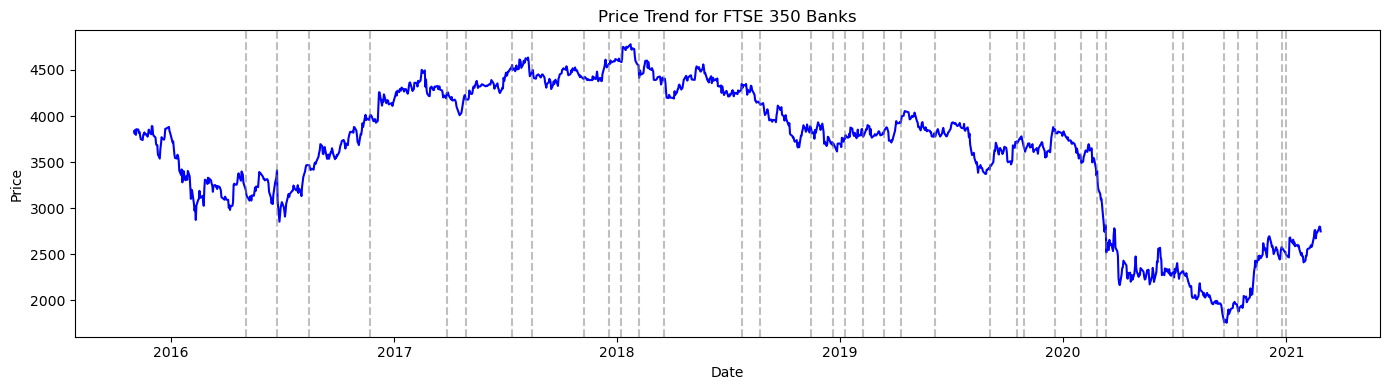

In [10]:
plot_price_trend_with_events(ftse350_bank_df, reg_df,  'FTSE 350 Banks', 'blue')

### Plot for FTSE 350 Insurance

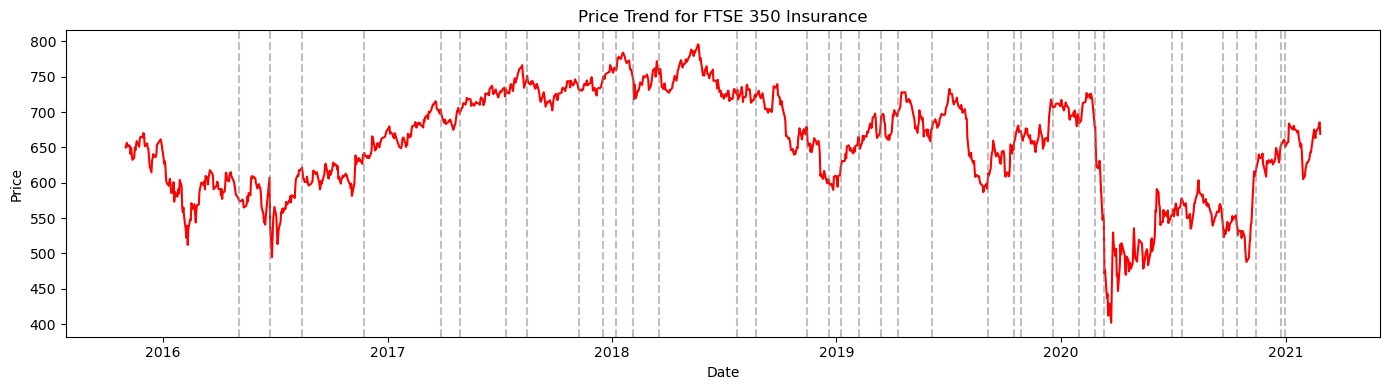

In [11]:
plot_price_trend_with_events(ftse350_insurance_df, reg_df,  'FTSE 350 Insurance', 'red')

### Plot for FTSE 350 Financial Services

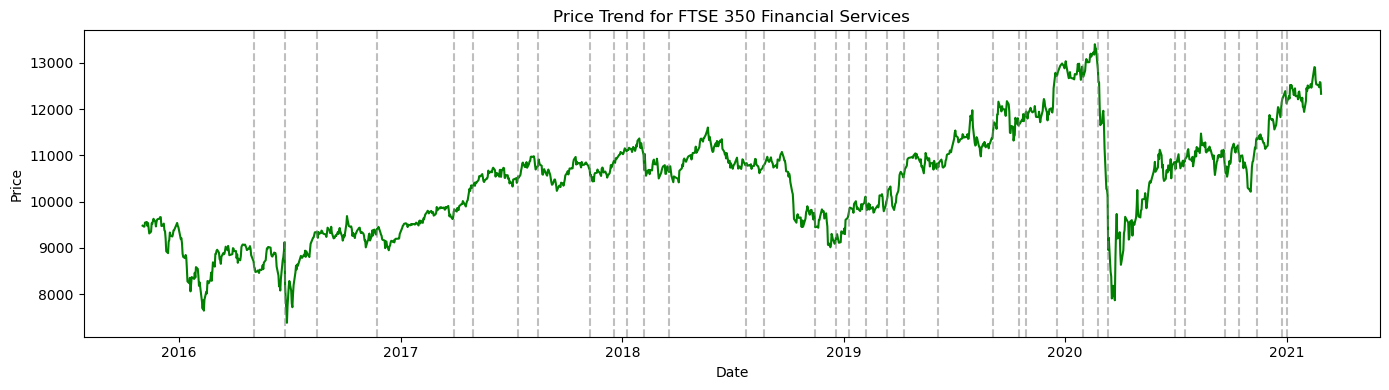

In [12]:
plot_price_trend_with_events(ftse350_financialservices_df, reg_df,  'FTSE 350 Financial Services', 'green')

### FTSE 350 Bank Volatility Plot

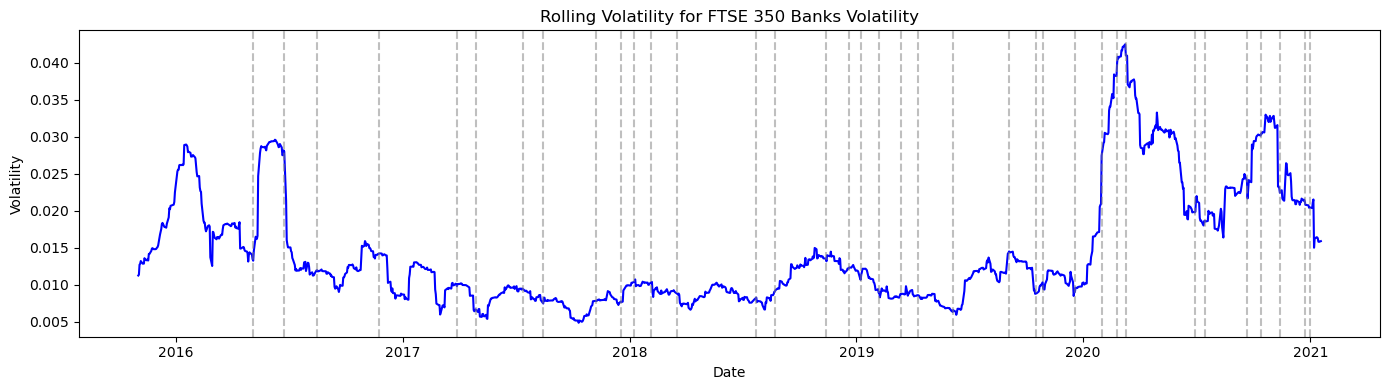

In [13]:
plot_volatility_with_events(ftse350_bank_df, reg_df,'FTSE 350 Banks Volatility', 'blue')

### FTSE 350 Insurance Volatility Plot

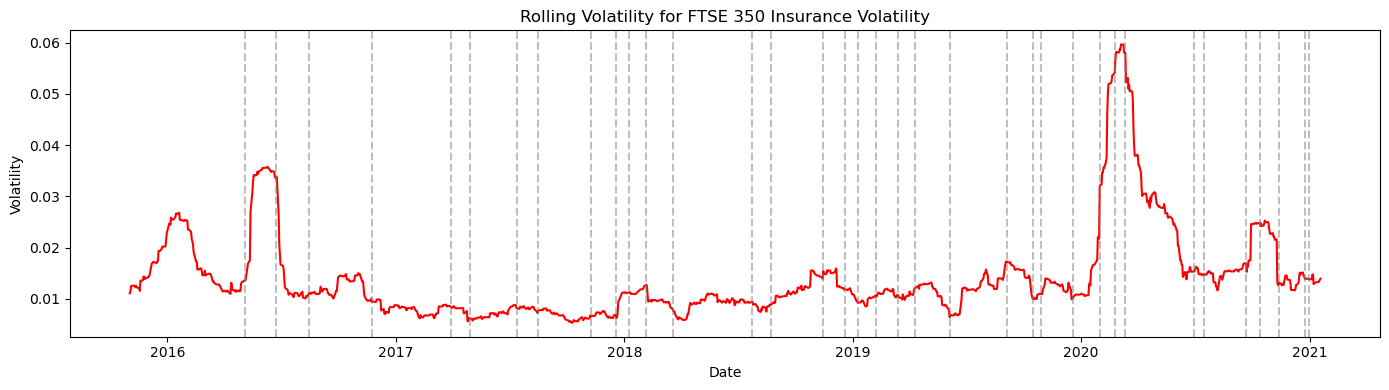

In [14]:
plot_volatility_with_events(ftse350_insurance_df, reg_df, 'FTSE 350 Insurance Volatility', 'red')

### FTSE 350 Financial Services Volatility Plot

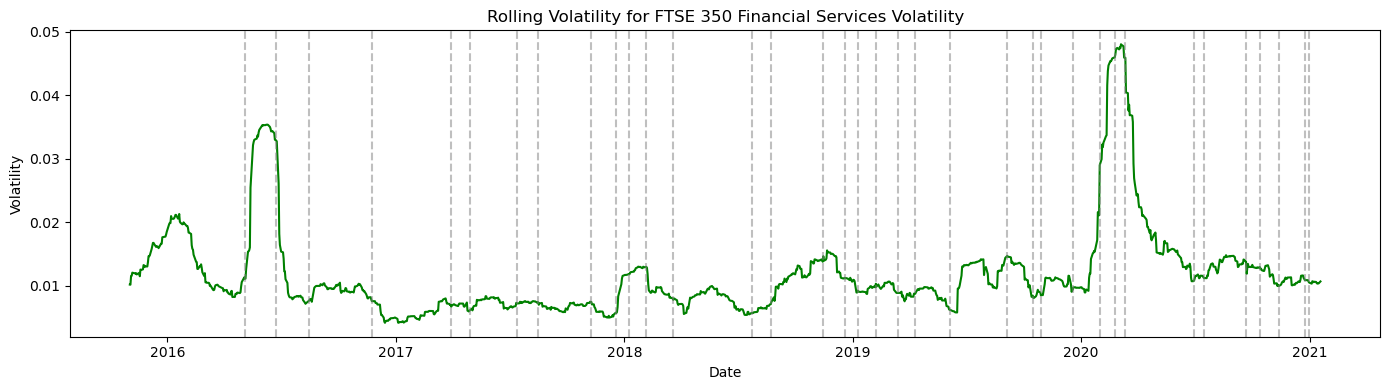

In [15]:
plot_volatility_with_events(ftse350_financialservices_df, reg_df, 'FTSE 350 Financial Services Volatility', 'green')

### Descriptive Statistics on Returns

In [16]:
# Extract the market reaction data around the announcement dates
announcement_dates = reg_df['Date']
market_reaction = get_market_reaction(full_data, announcement_dates)

# Calculate cumulative returns in the window for each sector
market_reaction['Cumulative_Returns_Banks'] = market_reaction['Banks'].cumsum()
market_reaction['Cumulative_Returns_Financial_Services'] = market_reaction['Financial_Services'].cumsum()
market_reaction['Cumulative_Returns_Insurance'] = market_reaction['Insurance'].cumsum()

# Display the summary statistics around the announcements
reaction_summary = market_reaction.groupby('Announcement_Date').agg({
    'Cumulative_Returns_Banks': ['sum', 'mean'],
    'Cumulative_Returns_Financial_Services': ['sum', 'mean'],
    'Cumulative_Returns_Insurance': ['sum', 'mean'],
    'Banks': ['std'],  # Example for volatility
    'Financial_Services': ['std'],
    'Insurance': ['std']
})

reaction_summary

Cumulative_Returns_Banks            \
                                       sum      mean   
Announcement_Date                                      
2016-05-04                         -0.1675 -0.005982   
2016-06-23                         -1.0125 -0.034914   
2016-08-15                          0.9848  0.035171   
2016-11-23                          5.4820  0.189034   
2017-03-29                          5.8541  0.216819   
2017-04-29                          4.7604  0.176311   
2017-07-13                          7.3540  0.253586   
2017-08-15                          7.0603  0.252154   
2017-11-08                          6.3629  0.219410   
2017-12-18                          6.4337  0.247450   
2018-01-08                          7.5094  0.288823   
2018-02-05                          8.1262  0.280214   
2018-03-19                          6.0546  0.224244   
2018-07-24                          6.1191  0.211003   
2018-08-23                          5.0342  0.179793   
2018-11-14                          5.3124  0.183186   
2018-12-20                          3.9357  0.151373   
2019-01-09                          4.3767  0.168335   
2019-02-07                          5.5968  0.192993   
2019-03-14                          5.7183  0.197183   
2019-04-11                          6.9428  0.257141   
2019-06-05                          7.0768  0.252743   
2019-09-04                          7.3320  0.261857   
2019-10-17                          8.5289  0.294100   
2019-10-29                         10.5814  0.364876   
2019-12-19                          9.4132  0.362046   
2020-01-31                          9.7831  0.337348   
2020-02-25                          6.7090  0.231345   
2020-03-11                         -5.6458 -0.194683   
2020-06-30                        -11.3920 -0.392828   
2020-07-16                        -12.5897 -0.434128   
2020-09-21                        -16.9014 -0.582807   
2020-10-13                        -13.3586 -0.460641   
2020-11-13                         -7.8048 -0.269131   
2020-12-24                         -4.2182 -0.162238   
2020-12-31                         -3.5607 -0.136950   

                  Cumulative_Returns_Financial_Services            \
                                                    sum      mean   
Announcement_Date                                                   
2016-05-04                                      -0.7982 -0.028507   
2016-06-23                                      -1.7375 -0.059914   
2016-08-15                                       0.1915  0.006839   
2016-11-23                                       1.2738  0.043924   
2017-03-29                                       0.4963  0.018381   
2017-04-29                                       1.7172  0.063600   
2017-07-13                                       2.5809  0.088997   
2017-08-15                                       3.2966  0.117736   
2017-11-08                                       2.4694  0.085152   
2017-12-18                                       2.9047  0.111719   
2018-01-08                                       4.1948  0.161338   
2018-02-05                                       4.8685  0.167879   
2018-03-19                                       3.7814  0.140052   
2018-07-24                                       4.2960  0.148138   
2018-08-23                                       4.2790  0.152821   
2018-11-14                                       5.1250  0.176724   
2018-12-20                                       3.1454  0.120977   
2019-01-09                                       5.5217  0.212373   
2019-02-07                                       7.2521  0.250072   
2019-03-14                                       7.9514  0.274186   
2019-04-11                                      10.0382  0.371785   
2019-06-05                                      11.7249  0.418746   
2019-09-04                                      13.6393  0.487118   
2019-10-17                             

- Using T Statistical Test for checking if the abnormal returns are Statistically Significant or not.

In [17]:
# Define the window for expected and event returns
pre_event_window = 10  # Days before the event to calculate expected returns
event_window = 10      # Days around the event to observe the actual impact

#### For FTSE 350 Banks

In [18]:
# Calculate the impact for FTSE 350 Banks
event_impact_banks = calculate_event_impact(ftse350_bank_df, reg_df['Date'], pre_event_window, event_window)

event_impact_banks

,Event Date,Expected Return,Mean Abnormal Return,T-Statistic,P-Value
0,2016-08-15,0.009367,-0.009000,-3.635972,0.006627
1,2016-11-23,0.004429,-0.006741,-3.134240,0.016512
2,2017-08-15,-0.005750,0.005350,2.424316,0.041569
3,2017-11-08,-0.003043,0.002680,2.463395,0.043250
4,2019-09-04,0.001117,0.009133,2.514139,0.040153
5,2019-10-17,0.007537,-0.005052,-2.730851,0.034147
6,2019-12-19,0.008075,-0.009375,-3.481307,0.025322


#### For FTSE 350 Financial Services

In [19]:
# Calculate the impact for FTSE 350 Financial Services
event_impact_financial_services = calculate_event_impact(ftse350_financialservices_df, reg_df['Date'], pre_event_window, event_window)

event_impact_financial_services

,Event Date,Expected Return,Mean Abnormal Return,T-Statistic,P-Value
0,2016-08-15,0.007300,-0.007422,-3.286993,0.011072
1,2016-11-23,0.003829,-0.006916,-3.702005,0.007635
2,2017-03-29,-0.003186,0.006473,2.830303,0.025395
3,2017-07-13,0.000425,0.004661,2.935578,0.026097
4,2019-12-19,0.007400,-0.003200,-2.777887,0.049926
5,2020-11-13,0.013625,-0.014982,-5.136983,0.002142


#### For FTSE 350 Insurance

In [20]:
# Calculate the impact for FTSE 350 Insurance
event_impact_insurance = calculate_event_impact(ftse350_insurance_df, reg_df['Date'], pre_event_window, event_window)

event_impact_insurance

,Event Date,Expected Return,Mean Abnormal Return,T-Statistic,P-Value
0,2016-05-04,-0.008733,0.005896,2.659405,0.032495
1,2016-08-15,0.006250,-0.010017,-3.254216,0.011627
2,2019-09-04,-0.002117,0.015917,4.218279,0.003945
3,2019-12-19,0.009012,-0.008513,-5.163360,0.006683
4,2020-07-16,0.005713,-0.012712,-3.087388,0.021459
5,2020-11-13,0.027100,-0.021271,-6.113216,0.000874


DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002665. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.
    
This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

It’s generally beneficial to rescale returns for volatility modeling due to improved numerical
stability, ease of interpretation, and potentially better performance of the optimization
algorithms used in parameter estimation. The essential relationships and dynamics captured by
the model are not altered by rescaling, so this practice does not fundamentally change
the model’s insights about volatility.

In [21]:
# Define the event window
window_size = 10

# Create a copy of the original 'Regulatory_Announcements' to adjust it
announcements_window = np.zeros(len(full_data))  # Initialize with 0s
announcement_dates = data.index[full_data['Regulatory_Announcements'] == 1].tolist()  # Get announcement dates

# Set the window for each announcement
for announcement_date in announcement_dates:
    start = max(0, announcement_date - window_size)
    end = min(len(full_data) - 1, announcement_date + window_size)
    announcements_window[start:end + 1] = 1  # Set 1 within the window

# Add the new window-based announcement variable to the DataFrame
full_data['Regulatory_Announcements_Window'] = announcements_window

### OLS Regression Test

In [22]:
# Define the independent variables matrix (add a constant to the model)
X = sm.add_constant(full_data['Regulatory_Announcements'])  # Adds a constant term to the predictor

# 'Banks' sector
y = full_data['Banks'] * 100

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Banks   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.094
Date:                Wed, 25 Sep 2024   Prob (F-statistic):              0.296
Time:                        04:54:44   Log-Likelihood:                -2571.0
No. Observations:                1347   AIC:                             5146.
Df Residuals:                    1345   BIC:                             5156.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

### Key Regression Results:

- **R-squared (0.001)**: The model explains only **0.1%** of the variation in bank returns, indicating that regulatory announcements have **very little explanatory power** for bank returns in this regression.
  
- **Regulatory Announcements Coefficient (-0.2925, p = 0.296)**: The coefficient is negative, suggesting a potential **negative impact** of regulatory announcements on bank returns. However, the p-value (**0.296**) is not statistically significant, meaning we **cannot confidently conclude** that regulatory announcements affect bank returns.
  
- **F-statistic (1.094, p = 0.296)**: The overall model is **not statistically significant**, indicating that regulatory announcements do not explain much variation in bank returns.

### Takeaway:
- Regulatory announcements **do not have a statistically significant impact** on bank returns in this regression, as the p-value is greater than 0.05, and the model explains very little of the return variation.


In [23]:
# 'Insurance' sector
y = full_data['Insurance'] * 100

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              Insurance   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7388
Date:                Wed, 25 Sep 2024   Prob (F-statistic):              0.390
Time:                        04:54:44   Log-Likelihood:                -2588.2
No. Observations:                1347   AIC:                             5180.
Df Residuals:                    1345   BIC:                             5191.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

### Key Regression Results:

- **R-squared (0.001)**: The model explains only **0.1%** of the variation in insurance returns, similar to the banks sector. This indicates that **regulatory announcements have minimal explanatory power** for insurance stock returns.
  
- **Regulatory Announcements Coefficient (-0.2435, p = 0.390)**: The coefficient is negative, suggesting that **regulatory announcements might decrease insurance returns**, but the p-value (**0.390**) is not statistically significant. We **cannot conclude** that regulatory announcements have a significant effect.
  
- **F-statistic (0.739, p = 0.390)**: The model is **not statistically significant**, implying that regulatory announcements **do not have a meaningful effect** on insurance returns.

### Takeaway:
- Regulatory announcements **do not significantly impact insurance returns**, as indicated by the high p-value and low explanatory power (**R-squared**).


In [24]:
# 'Financial_Services' sector
y = full_data['Financial_Services'] * 100

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     Financial_Services   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.324
Date:                Wed, 25 Sep 2024   Prob (F-statistic):              0.250
Time:                        04:54:44   Log-Likelihood:                -2334.2
No. Observations:                1347   AIC:                             4672.
Df Residuals:                    1345   BIC:                             4683.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

### Key Regression Results:

- **R-squared (0.001)**: The model explains only **0.1%** of the variation in **financial services returns**, indicating that **regulatory announcements have very little explanatory power** for this sector.
  
- **Regulatory Announcements Coefficient (-0.2700, p = 0.250)**: The coefficient is negative, suggesting that **regulatory announcements may decrease financial services returns**. However, the p-value (**0.250**) is not statistically significant, so we **cannot confirm this effect**.
  
- **F-statistic (1.324, p = 0.250)**: The overall model is **not statistically significant**, implying that **regulatory announcements are not strong predictors** of financial services returns.

### Takeaway:
- Regulatory announcements **do not have a statistically significant impact** on **financial services returns**, as indicated by the model's low **R-squared** and non-significant p-value.


#### GARCH EGARCH GJR-GARCH

##### FTSE 350 Bank Data

In [25]:
returns = ftse350_bank_df.Returns.dropna()

# Fit the models to your returns data
models_results = fit_garch_model_with_window(returns, announcements_window)

# Display the summary of each model's results
for model_name, result in models_results.items():
    print(f"Results for {model_name}:")
    print(result.summary())
    print("\n")

Results for GARCH:
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -2321.30
Distribution:                  Normal   AIC:                           4648.59
Method:            Maximum Likelihood   BIC:                           4664.21
                                        No. Observations:                 1347
Date:                Wed, Sep 25 2024   Df Residuals:                     1347
Time:                        04:54:44   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0173  1.336e-02    

### GARCH Model:
- **Volatility** responds quickly to recent shocks (**alpha = 0.2019**, *p* < 0.001), but is less persistent (**beta = 0.7527**, *p* < 0.001) compared to other sectors.

### EGARCH Model:
- **Negative news** has a stronger effect on volatility than positive news (**alpha = 0.3474**, *p* < 0.001), showing a clear asymmetric response.

### GJR-GARCH Model:
- **Negative events** significantly increase volatility (**gamma = 0.1578**, *p* = 0.003), with a strong asymmetry in the market’s reaction.

### Takeaway:
- The banking sector reacts quickly to both good and bad news, but bad news causes much higher spikes in volatility.

##### FTSE 350 Insurance Data

In [26]:
returns = ftse350_insurance_df.Returns.dropna()

# Fit the models to your returns data
models_results = fit_garch_model_with_window(returns, announcements_window)

# Display the summary of each model's results
for model_name, result in models_results.items():
    print(f"Results for {model_name}:")
    print(result.summary())
    print("\n")

Results for GARCH:
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -2264.04
Distribution:                  Normal   AIC:                           4534.07
Method:            Maximum Likelihood   BIC:                           4549.69
                                        No. Observations:                 1347
Date:                Wed, Sep 25 2024   Df Residuals:                     1347
Time:                        04:54:44   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.0700  3.355e-02      2.085  

### GARCH Model:
- **Volatility** is highly persistent (**beta = 0.9186**, *p* < 0.001), meaning that once a shock occurs, the impact on volatility lasts for a long time.
- The **ARCH effect** (**alpha = 0.0792**, *p* = 0.012) shows that past returns significantly impact current volatility.

### EGARCH Model:
- **Negative news** has a stronger impact on volatility than positive news (**alpha = 0.1884**, *p* < 0.001), indicating an asymmetric response.
- **Volatility** is highly persistent (**beta = 0.9905**, *p* < 0.001), similar to the GARCH model.

### GJR-GARCH Model:
- **Asymmetry** exists (**gamma = 0.0662**, *p* = 0.078), meaning bad news increases volatility more than good news, though this effect is less significant here.

### Takeaway:
- The insurance sector shows a strong and persistent reaction to past shocks, with bad news significantly increasing volatility. This is supported by low p-values (p < 0.05) for most key coefficients, indicating statistical significance.

##### FTSE 350 Financial Services Data

In [27]:
returns = ftse350_financialservices_df.Returns.dropna() #FTSE 350 Financial Services Data

# Fit the models to your returns data
models_results = fit_garch_model_with_window(returns, announcements_window)

# Display the summary of each model's results
for model_name, result in models_results.items():
    print(f"Results for {model_name}:")
    print(result.summary())
    print("\n")

Results for GARCH:
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -2019.45
Distribution:                  Normal   AIC:                           4044.90
Method:            Maximum Likelihood   BIC:                           4060.51
                                        No. Observations:                 1347
Date:                Wed, Sep 25 2024   Df Residuals:                     1347
Time:                        04:54:44   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.0813  3.336e-02      2.437  

### GARCH Model:
- **Past volatility** strongly impacts current volatility (**alpha = 0.1531**, *p* < 0.001), showing that shocks have an immediate effect.
- However, **volatility** is less persistent (**beta = 0.8234**, *p* < 0.001) than in the insurance sector.

### EGARCH Model:
- **Negative news** significantly increases volatility (**alpha = 0.3017**, *p* < 0.001), with a large asymmetric response.
- **Volatility** remains highly persistent (**beta = 0.9677**, *p* < 0.001).

### GJR-GARCH Model:
- The **asymmetry** is strong (**gamma = 0.1345**, *p* = 0.003), showing that negative events cause much higher volatility increases.

### Takeaway:
- The financial services sector **reacts quickly to shocks**, with **bad news** leading to significant volatility spikes (*p*-values < 0.05 for key parameters), but the volatility doesn’t last as long as in the insurance sector.


### Granger causality test

In [28]:
# The 'full_data' includes columns for 'Banks', 'Financial_Services', and 'Insurance'
granger_results = run_granger_tests(full_data, ['Banks', 'Financial_Services', 'Insurance'])


Testing Granger Causality for Banks caused by Regulatory Announcements:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.6295  , p=0.0058  , df_denom=1343, df_num=1
ssr based chi2 test:   chi2=7.6466  , p=0.0057  , df=1
likelihood ratio test: chi2=7.6249  , p=0.0058  , df=1
parameter F test:         F=7.6295  , p=0.0058  , df_denom=1343, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.8337  , p=0.0219  , df_denom=1340, df_num=2
ssr based chi2 test:   chi2=7.6961  , p=0.0213  , df=2
likelihood ratio test: chi2=7.6741  , p=0.0216  , df=2
parameter F test:         F=3.8337  , p=0.0219  , df_denom=1340, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7969  , p=0.0390  , df_denom=1337, df_num=3
ssr based chi2 test:   chi2=8.4345  , p=0.0378  , df=3
likelihood ratio test: chi2=8.4082  , p=0.0383  , df=3
parameter F test:         F=2.7969  , p=0.0390  , df_denom=1337, df_num=3

Granger Causal

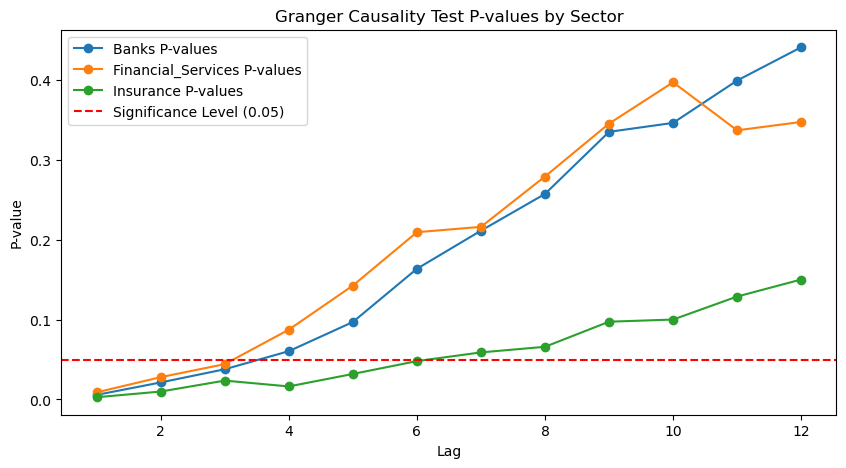

In [29]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
for sector, values in granger_results.items():
    lags = list(values.keys())
    p_values = list(values.values())
    ax.plot(lags, p_values, marker='o', label=f'{sector} P-values')

ax.axhline(0.05, color='red', linestyle='--', label='Significance Level (0.05)')
ax.set_xlabel('Lag')
ax.set_ylabel('P-value')
ax.set_title('Granger Causality Test P-values by Sector')
ax.legend()
plt.show()

### Overall Conclusion for All Sectors

**Granger Causality**: Regulatory announcements Granger-cause stock returns in the **Banks**, **Financial Services**, and **Insurance** sectors, particularly at shorter lags (1 to 3).
  
- **Immediate Impact**: The impact is strongest at **lag 1** for all sectors, indicating that regulatory announcements have an **immediate and significant effect** on stock returns.
  
- **Longer-term Effects**: The **Insurance** sector shows longer-term effects (up to **lag 5**), suggesting that regulatory announcements have a more **persistent impact** on insurance stocks compared to banks and financial services.
  
- **Sensitivity of Returns**: **Banks** and **Financial Services** exhibit strong Granger causality at **lag 1**, indicating that their returns are highly sensitive to regulatory news in the short term. However, the effects diminish beyond **lag 3**.

- **Predictive Power**: These findings suggest that regulatory announcements can **predict changes in stock returns**, with the most significant effects occurring **immediately after the announcement**, particularly for the **insurance sector**.


# Summary

# Interpretation of Models Across Sectors

| **Model**             | **Sector**                | **Key Findings**                                                                                  | **Conclusion**                                                                                                                                                                        |
|-----------------------|---------------------------|----------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **OLS Model**          | **Insurance**             | - **Regulatory_Announcements Coefficient (-0.2435, p = 0.390):** No statistically significant effect. | No significant impact of regulatory announcements on insurance returns detected by the OLS model.                                                                                     |
|                       | **Banks**                 | - **Regulatory_Announcements Coefficient (-0.2925, p = 0.296):** No statistically significant effect. | No significant impact of regulatory announcements on banking returns detected by the OLS model.                                                                                       |
|                       | **Financial Services**     | - **Regulatory_Announcements Coefficient (-0.2700, p = 0.250):** No statistically significant effect. | No significant impact of regulatory announcements on financial services returns detected by the OLS model.                                                                            |
| **GARCH Model**        | **Insurance**             | - **Alpha[1] (0.0792, p = 0.012), Beta[1] (0.9186, p < 0.001):** Persistent volatility post-announcements. | Regulatory announcements **increase volatility**, and the effect is **long-lasting**.                                                                                                |
|                       | **Banks**                 | - **Alpha[1] (0.2019, p < 0.001), Beta[1] (0.7527, p < 0.001):** Volatility increases but less persistent. | Regulatory announcements **increase volatility**, but banks recover quicker compared to other sectors.                                                                               |
|                       | **Financial Services**     | - **Alpha[1] (0.1531, p < 0.001), Beta[1] (0.8234, p < 0.001):** Increased volatility, lower persistence. | Volatility increases after regulatory announcements, but the persistence is lower than in the insurance sector.                                                                       |
| **EGARCH Model**       | **Insurance**             | - **Alpha[1] (0.1884, p < 0.001):** Asymmetric response, negative news causes greater volatility.    | **Negative news** (e.g., regulatory announcements) causes a **strong increase in volatility** in the insurance sector.                                                               |
|                       | **Banks**                 | - **Alpha[1] (0.3474, p < 0.001):** Strong asymmetric response to negative news.                     | Regulatory announcements lead to a **strong rise in volatility**, especially after **negative news**.                                                                                 |
|                       | **Financial Services**     | - **Alpha[1] (0.3017, p < 0.001):** Negative news drives higher volatility.                          | Regulatory announcements lead to **higher volatility** in the financial services sector, particularly after **negative announcements**.                                               |
| **GJR-GARCH Model**    | **Insurance**             | - **Gamma[1] (0.0662, p = 0.078):** Weaker asymmetric effect of negative news on volatility.         | Negative regulatory announcements **increase volatility**, but the impact is slightly weaker than in other models.                                                                    |
|                       | **Banks**                 | - **Gamma[1] (0.1578, p = 0.003):** Significant asymmetric effect, negative news drives volatility.  | Negative regulatory announcements **cause significant increases in volatility**.                                                                                                      |
|                       | **Financial Services**     | - **Gamma[1] (0.1578, p = 0.003):** Significant asymmetry, with negative news driving volatility.    | Regulatory announcements, particularly **negative ones**, **increase volatility** significantly in financial services.                                                                |
| **Granger Causality**  | **Insurance**             | - **Lag 1 (F = 8.8904, p = 0.0029):** Regulatory announcements Granger-cause insurance returns.      | Regulatory announcements **Granger-cause insurance returns**, with the strongest effect at lag 1.                                                                                     |
|                       | **Banks**                 | - **Lag 1 (F = 7.6295, p = 0.0058):** Regulatory announcements Granger-cause bank returns.           | Regulatory announcements **Granger-cause bank returns**, with the strongest effect at lag 1.                                                                                          |
|                       | **Financial Services**     | - **Lag 1 (F = 6.8275, p = 0.0091):** Regulatory announcements Granger-cause financial services returns. | Regulatory announcements **Granger-cause financial services returns**, with the strongest effect at lag 1.                                                                            |
